# Imports

In [1]:
from scipy.stats import levene, shapiro, kruskal
from scikit_posthocs import posthoc_dunn
from statsmodels.api import qqplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use("fivethirtyeight")

ALPHA = 0.05

# Load Data

In [2]:
df = pd.read_csv("../data/PostTypeAnalysisDateset.csv", parse_dates=["post_date"], )
df.head()

,post_date,entity_id,followers,is_picture,is_video,video_duration_secs,impressions,likes,shares,replies,engagement_rate
0,2020-01-02 17:10:00,7AD030340F434EECA5B4FC28034E1113,242458.0,False,False,NaN,36023.36585,123,3,42,0.000693
1,2020-01-02 17:46:00,7AD030340F434EECA5B4FC28034E1113,242458.0,False,False,NaN,23402.68323,4,0,0,0.000017
2,2020-10-09 16:06:00,4AAFEFB838974FDCA41932C4D32FD52A,2102820.0,False,False,NaN,204639.92030,24,1,2,0.000013
3,2020-10-09 16:08:00,4AAFEFB838974FDCA41932C4D32FD52A,2102820.0,False,False,NaN,208872.73630,91,1,2,0.000045
4,2020-10-10 13:00:00,4A3372EBDC9C484AA8503A96CD14B858,1023570.0,False,False,NaN,136020.57130,465,9,2,0.000465


# Basic inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15141 entries, 0 to 15140
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_date            15141 non-null  datetime64[ns]
 1   entity_id            15141 non-null  object        
 2   followers            15127 non-null  float64       
 3   is_picture           15141 non-null  bool          
 4   is_video             15141 non-null  bool          
 5   video_duration_secs  1989 non-null   float64       
 6   impressions          15127 non-null  float64       
 7   likes                15141 non-null  int64         
 8   shares               15141 non-null  int64         
 9   replies              15141 non-null  int64         
 10  engagement_rate      15141 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 1.1+ MB


In [4]:
df.corr()

,followers,is_picture,is_video,video_duration_secs,impressions,likes,shares,replies,engagement_rate
followers,1.000000,0.016508,0.100099,0.106794,0.724790,0.350091,0.173889,0.150352,0.007454
is_picture,0.016508,1.000000,-0.260432,NaN,0.095042,0.099921,0.069715,0.010118,0.092886
is_video,0.100099,-0.260432,1.000000,NaN,0.135577,0.091428,0.079929,-0.004282,0.101643
video_duration_secs,0.106794,NaN,NaN,1.000000,0.189965,0.190438,0.153070,0.070784,0.218934
impressions,0.724790,0.095042,0.135577,0.189965,1.000000,0.882955,0.558378,0.335227,0.560186
likes,0.350091,0.099921,0.091428,0.190438,0.882955,1.000000,0.644512,0.386018,0.766413
shares,0.173889,0.069715,0.079929,0.153070,0.558378,0.644512,1.000000,0.334081,0.479210
replies,0.150352,0.010118,-0.004282,0.070784,0.335227,0.386018,0.334081,1.000000,0.194163
engagement_rate,0.007454,0.092886,0.101643,0.218934,0.560186,0.766413,0.479210,0.194163,1.000000


In [5]:
df["post_date"].describe(datetime_is_numeric=True) # posts are from 2020/1 - 2020/12

count                            15141
mean     2020-07-11 08:02:11.202694400
min                2020-01-01 05:01:00
25%                2020-04-18 18:45:00
50%                2020-07-26 00:04:00
75%                2020-10-02 00:20:00
max                2020-12-16 04:02:00
Name: post_date, dtype: object

In [6]:
df["entity_id"].nunique() # only come from 5 accounts

5

In [7]:
df.isnull().sum()

post_date                  0
entity_id                  0
followers                 14
is_picture                 0
is_video                   0
video_duration_secs    13152
impressions               14
likes                      0
shares                     0
replies                    0
engagement_rate            0
dtype: int64

#### Analysis is about impressions/engagement rate and post type. Dropping all other columns for the assignment but could go back and see if there's anything interesting there

In [8]:
def group(pic: bool, vid: bool) -> str:
    if pic and vid:
        return "both"
    elif pic:
        return "pic"
    elif vid:
        return "vid"
    else:
        return "text"

In [9]:
df["post_type"] = df.apply(lambda x: group(x["is_picture"], x["is_video"]), axis=1)
df = df.dropna(subset="followers")
df.drop(axis=1, labels=["post_date", "entity_id", "followers", "likes", "shares", "replies", "is_picture", "is_video"], inplace=True)

In [10]:
df.info() # sanity check for the changes i did previously

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15127 entries, 0 to 15140
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_duration_secs  1987 non-null   float64
 1   impressions          15127 non-null  float64
 2   engagement_rate      15127 non-null  float64
 3   post_type            15127 non-null  object 
dtypes: float64(3), object(1)
memory usage: 590.9+ KB


# EDA of Impressions by `post_type`

In [11]:
df["post_type"].value_counts()

text    8456
pic     4684
vid     1987
Name: post_type, dtype: int64

In [12]:
pic, vid, text = df[df["post_type"] == "pic"].copy(), df[df["post_type"] == "vid"].copy(), df[df["post_type"] == "text"].copy() # not using groupby because I wantt to overlay plots

In [13]:
pic.head()

,video_duration_secs,impressions,engagement_rate,post_type
6,NaN,100555.51020,0.000076,pic
8,NaN,123367.91710,0.000228,pic
10,NaN,99865.14892,0.000155,pic
16,NaN,97259.44427,0.000149,pic
29,NaN,97807.21347,0.000054,pic


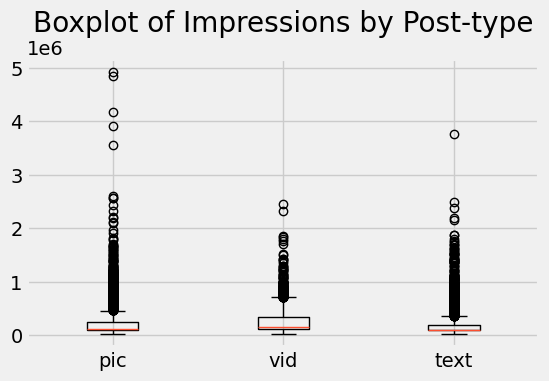

In [14]:
fig, ax = plt.subplots()
ax.boxplot([pic["impressions"], vid["impressions"], text["impressions"]], labels=["pic", "vid", "text"])
plt.title("Boxplot of Impressions by Post-type")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/imp_box.jpg")
plt.show()

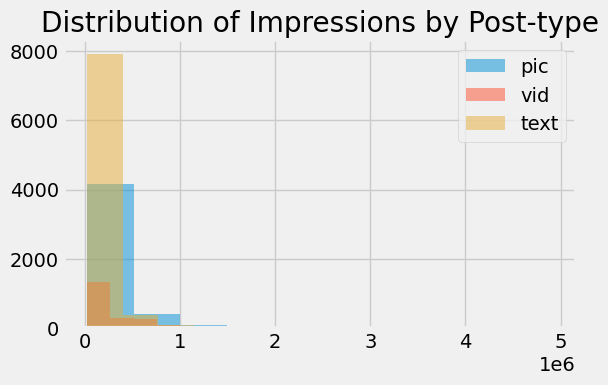

In [15]:
plt.hist(pic["impressions"], label="pic", alpha=.5)
plt.hist(vid["impressions"], label="vid", alpha=.5)
plt.hist(text["impressions"], label="text", alpha=.5)
plt.legend()
plt.title("Distribution of Impressions by Post-type")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/imp_hist.jpg")
plt.show()

##### It's hard to say from these plots if there's a difference between groups

## Hypothesis Testing: Impressions

### Checking Assumptions so I can figure out what test I can use

#### Normality

Pretty clearly the data is not normally distributed but will formally test since it doesn't cost me anything

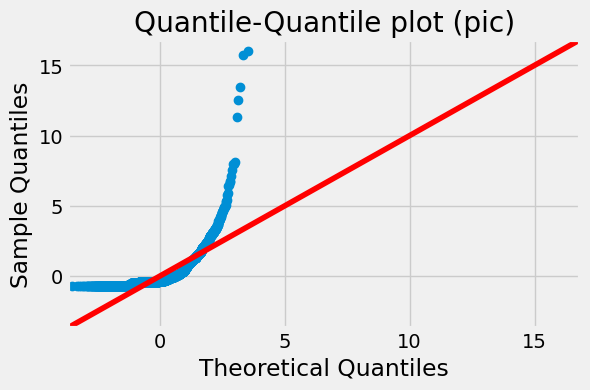

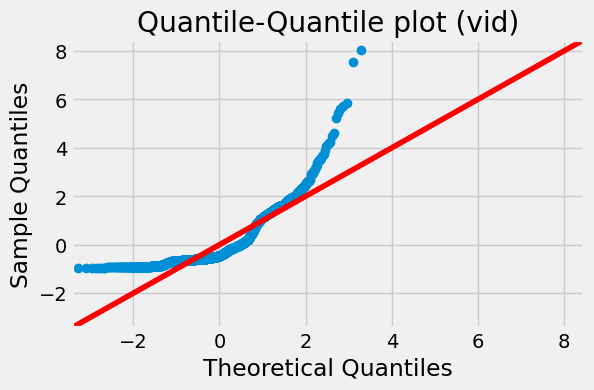

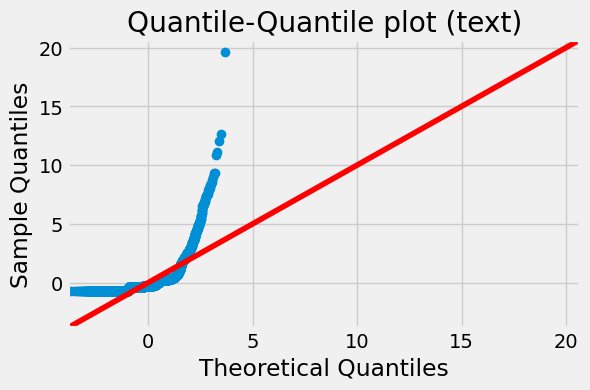

In [16]:
qqplot(pic["impressions"], fit=True, line="45")
plt.title("Quantile-Quantile plot (pic)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_imp1.jpg")
qqplot(vid["impressions"], fit=True, line="45")
plt.title("Quantile-Quantile plot (vid)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_imp2.jpg")
qqplot(text["impressions"], fit=True, line="45")
plt.title("Quantile-Quantile plot (text)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_imp3.jpg")
plt.show()

In [17]:
shapiro(pic["impressions"]).pvalue < ALPHA, shapiro(vid["impressions"]).pvalue < ALPHA, shapiro(text["impressions"]).pvalue < ALPHA

C:\Users\allan\.virtualenvs\eg_assessment-nlFCfaXA\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(True, True, True)

Tests & qq-plots confirm suspicion of non-normality. Does throw a warning but visually this is the case and an iffy test agrees

#### Equal Variances

In [18]:
pic["impressions"].var(), vid["impressions"].var(), text["impressions"].var()

(85881046078.35025, 73911366360.06158, 33696350415.36723)

In [19]:
levene(pic["impressions"], vid["impressions"], text["impressions"]).pvalue < ALPHA

True

Tests confirms variances are unequal

## Testing

Using **Kruskal-Wallis** because data is non-parametric and variances are unequal

H<sub>0</sub>: The medians of impressions between post-types are the same

H<sub>1</sub>: The medians of impressions between the post-types are unequal

In [20]:
kruskal(pic["impressions"], vid["impressions"], text["impressions"]).pvalue < ALPHA

True

Medians between groups are statistically significantly different from each other. Using **Dunn-test** for post-hoc analysis

In [21]:
imp_posthoc_res = posthoc_dunn(a=[pic["impressions"], vid["impressions"], text["impressions"]], p_adjust="bonferroni", )
imp_posthoc_res.rename(columns={1: "pic", 2: "vid", 3: "text"}, inplace=True)
imp_posthoc_res.rename(index={1: "pic", 2: "vid", 3: "text"}, inplace=True)
imp_posthoc_res.head()

,pic,vid,text
pic,1.000000e+00,1.795549e-26,2.870941e-91
vid,1.795549e-26,1.000000e+00,6.126783e-153
text,2.870941e-91,6.126783e-153,1.000000e+00


Between **ALL** groups, the median impressions are statistically significantlly different

## Confidence Interval for Median by Post-type

In [22]:
def bootstrap(dist: list, alpha=95, iters=10000) -> tuple[float]:
    low = (100 - alpha) / 2
    medians = np.array([])
    for i in range(iters):
        sample = dist.sample(dist.shape[0], replace=True)
        medians = np.append(medians, sample.median())
    return round(np.percentile(medians, low), 5), round(np.percentile(medians, alpha + low), 5)

In [23]:
conf_int_post = {
    "pic": bootstrap(pic["impressions"]),
    "vid": bootstrap(vid["impressions"]),
    "text": bootstrap(text["impressions"])
}

In [24]:
conf_int_post

{'pic': (120119.41145, 124997.5776),
 'vid': (147948.0467, 168042.9731),
 'text': (102447.24425, 104534.0704)}

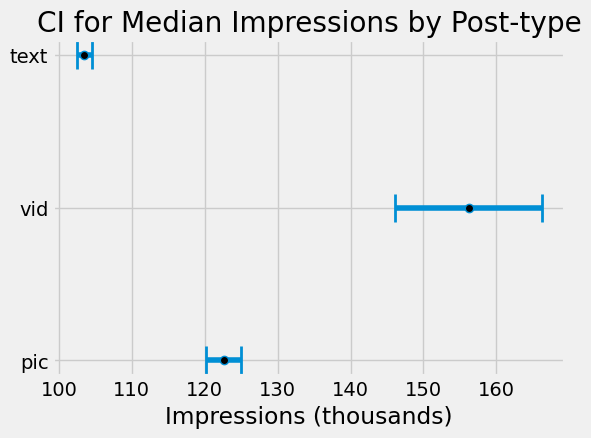

In [25]:
plt.errorbar(
    x=[pic["impressions"].median(), vid["impressions"].median(), text["impressions"].median()],
    y=range(3), xerr=[(x[1] - x[0]) / 2 for x in conf_int_post.values()], ls="none", marker="o",
    capsize=10, capthick=2, markerfacecolor="black"
)
plt.title("CI for Median Impressions by Post-type")
plt.yticks(ticks=range(3), labels=["pic", "vid", "text"])
plt.xticks(ticks=range(100000, 160001, 10000), labels=range(100, 161, 10))
plt.xlabel("Impressions (thousands)")
plt.subplots_adjust(left=.1, right=.9, top=.85, bottom=.15)
plt.savefig("../img/boot_imp.jpg")
plt.show()

## Results

The Kruskal-Wallis test found that there is a statistically significant difference (alpha=.05) between median impressions by post-type. The post-hoc Dunn test found that all groups are statistically significant from each other. I found that video posts, have median impressions between 148146.83 and 167897.54 (CL=95) by bootstrapping. Both posts with videos and post with pictures significantly outpreform text posts; however, among video and picture posts, video way outpreform pictures. I recommend that we include videos in our posts.

# EDA of Egagement Rate by `post_type`

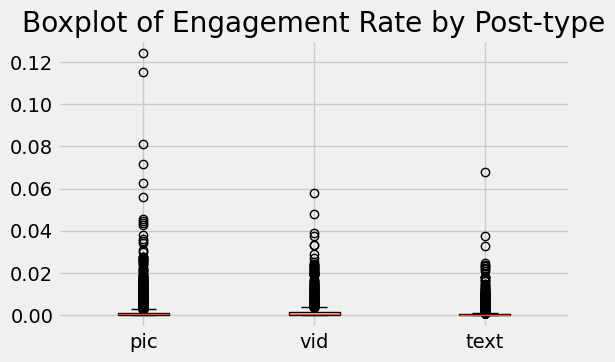

In [26]:
fig, ax = plt.subplots()
ax.boxplot([pic["engagement_rate"], vid["engagement_rate"], text["engagement_rate"]], labels=["pic", "vid", "text"])
plt.title("Boxplot of Engagement Rate by Post-type")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/eng_box.jpg")
plt.show()

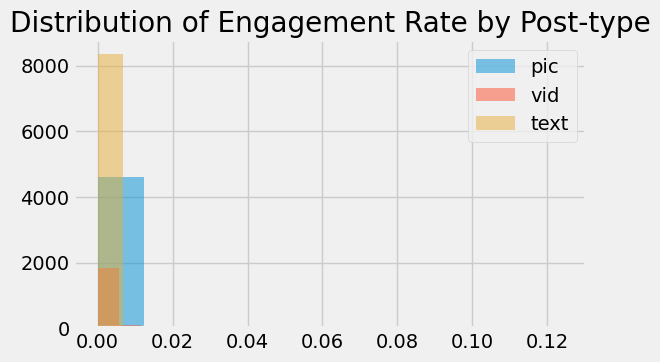

In [27]:
plt.hist(pic["engagement_rate"], label="pic", alpha=.5)
plt.hist(vid["engagement_rate"], label="vid", alpha=.5)
plt.hist(text["engagement_rate"], label="text", alpha=.5)
plt.legend()
plt.title("Distribution of Engagement Rate by Post-type")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/eng_hist.jpg")
plt.show()

##### Again these vizualizations are hard to gleam anything from

## Hypothesis Testing: Engagement Rate

### Checking Assumptions so I can figure out what test I can use

#### Normality

In [ ]:
qqplot(pic["engagement_rate"], fit=True, line="45")
plt.title("Quantile-Quantile plot (pic)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_eng1.jpg")
qqplot(vid["engagement_rate"], fit=True, line="45")
plt.title("Quantile-Quantile plot (vid)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_eng2.jpg")
qqplot(text["engagement_rate"], fit=True, line="45")
plt.title("Quantile-Quantile plot (text)")
plt.subplots_adjust(left=.1, right=.9, top=.8, bottom=.2)
plt.savefig("../img/qq_eng3.jpg")
plt.show()

In [ ]:
shapiro(pic["engagement_rate"]).pvalue < ALPHA, shapiro(vid["engagement_rate"]).pvalue < ALPHA, shapiro(text["engagement_rate"]).pvalue < ALPHA

Test, qq-plot and histrograms agree. Data is not normally distributed

#### Equal Variance

In [ ]:
pic["engagement_rate"].var(), vid["engagement_rate"].var(), text["engagement_rate"].var()

In [ ]:
levene(pic["engagement_rate"], vid["engagement_rate"], text["engagement_rate"]).pvalue < ALPHA

## Testing

Using **Kruskal-Wallis** because data is non-parametric and variances are unequal

H<sub>0</sub>: The medians of engagement rate between post-types are the same

H<sub>1</sub>: The medians of engagement rate between the post-types are unequal

In [ ]:
kruskal(pic["engagement_rate"], vid["engagement_rate"], text["engagement_rate"]).pvalue < ALPHA

Medians between groups are statistically significantly different from each other. Using **Dunn-test** for post-hoc analysis

In [ ]:
eng_posthoc_res = posthoc_dunn(a=[pic["engagement_rate"], vid["engagement_rate"], text["engagement_rate"]], p_adjust="bonferroni", )
eng_posthoc_res.rename(columns={1: "pic", 2: "vid", 3: "text"}, inplace=True)
eng_posthoc_res.rename(index={1: "pic", 2: "vid", 3: "text"}, inplace=True)
eng_posthoc_res.head()

Between **ALL** groups, the median impressions are statistically significantlly different

## Confidence Interval for Median by Post-type

In [ ]:
eng_conf_int_post = {
    "pic": bootstrap(pic["engagement_rate"]),
    "vid": bootstrap(vid["engagement_rate"]),
    "text": bootstrap(text["engagement_rate"])
}

In [ ]:
eng_conf_int_post

In [ ]:
plt.errorbar(
    x=[pic["engagement_rate"].median(), vid["engagement_rate"].median(), text["engagement_rate"].median()],
    y=range(3), xerr=[(x[1] - x[0]) / 2 for x in eng_conf_int_post.values()], ls="none", marker="o",
    capsize=10, capthick=2, markerfacecolor="black"
)
plt.title("CI for Median Engagement Rate by Post-type")
plt.yticks(ticks=range(3), labels=["pic", "vid", "text"])
plt.xlabel("Engagement Rate")
plt.subplots_adjust(left=.1, right=.9, top=.85, bottom=.15)
plt.savefig("../img/boot_eng.jpg")
plt.show()

## Results

The results we got for impressions are mirrored here. Kruskal-Wallis showed there's a statistically significant difference between group medians. The post-hoc Dunn test showed that all groups are different from eachother and bootsrapping medians showed that vid out preformed pic posts and pic outpreformed text posts. Given that both tests resulted in similar results I recommend we include a videos in our twitter posts.